In [1]:
import sys

sys.path.append('../')

import rings2cosmo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Math
from scipy.optimize import curve_fit
import corner

### Using 80 objects

Data from [Test of parametrized post-Newtonian gravity with galaxy-scale strong lensing systems](https://arxiv.org/abs/1701.00357).

In [2]:
data_80 = pd.read_csv('../data/sample80.csv')
data_80.head()

,name,zl,zs,sigma_0,dsigma_0,theta_E,theta_ap,sigma_atm,sigma_ap,d_sigma_ap
0,J2321-0939,0.082,0.532,246,8,1.60,1.5,1.4,249,8
1,J1106+5228,0.096,0.407,268,13,1.23,1.5,1.4,262,13
2,J1143-0144,0.106,0.402,264,13,1.68,1.5,1.4,269,13
3,J0841+3824,0.116,0.657,222,11,1.41,1.5,1.4,225,11
4,J0044+0113,0.120,0.196,267,13,0.79,1.5,1.4,266,13


In [3]:
len(data_80)

80

In [4]:
data = data_80
z_L = data['zl'].values
z_S = data['zs'].values
theta_E = (data['theta_E'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
theta_ap = (data['theta_ap'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
seeing_atm = (data['sigma_atm'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
velDisp = data['sigma_ap'].values
velDispErr = data['d_sigma_ap'].values

In [5]:
rings2cosmo.minimization_loglikelihood(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                               seed = 11, alpha_ini = 2.0, beta_ini = 0.18, gamma_ini = 1.0, delta = 2.4)

(1.8620708694903378, 0.14372114225348534, 0.768637130462804)

In [6]:
rings2cosmo.minimization_logprobability(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                                seed = 11, alpha_ini = 2.0, beta_ini = 0.18, gamma_ini = 1.0, delta = 2.4, \
                                alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13)

/share/storage1/TNG/Softwares/anaconda3-2020.02/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/share/storage1/TNG/Softwares/anaconda3-2020.02/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


(1.9955363015576117, 0.17999999392944413, 0.9955441205096968)

In [7]:
rings2cosmo.logprobability_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                            seed = 11, alpha_ini = 2.0, beta_ini = 0.18, gamma_ini = 1.0, delta = 2.4, 
                            alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13, 
                            n_dim = 3, n_walkers = 64, n_burn = 500, n_steps = 1000, progress = True, processes = 10)

Running burn-in ...


100%|████████████████████████████████████████| 500/500 [00:10<00:00, 47.87it/s]


Sampling ...


100%|██████████████████████████████████████| 1000/1000 [00:20<00:00, 48.28it/s]


In [8]:
sampler = rings2cosmo.logprobability_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                            seed = 11, alpha_ini = 2.0, beta_ini = 0.18, gamma_ini = 1.0, delta = 2.4, 
                            alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13, 
                            n_dim = 3, n_walkers = 64, n_burn = 500, n_steps = 10000, progress = True, processes = 10)

Running burn-in ...


100%|████████████████████████████████████████| 500/500 [00:10<00:00, 49.48it/s]


Sampling ...


100%|████████████████████████████████████| 10000/10000 [03:22<00:00, 49.36it/s]


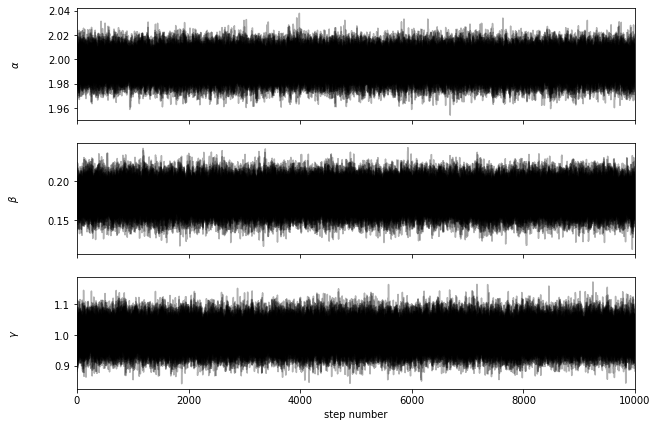

In [9]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [10]:
tau = sampler.get_autocorr_time()
print(tau)

[39.27331491 39.28943141 37.90617507]


In [11]:
flat_samples = sampler.get_chain(discard=500, thin=40, flat=True)
print(flat_samples.shape)

(15168, 3)


In [12]:
"Mean acceptance fraction: {0:.3f}".format(rings2cosmo.np.mean(sampler.acceptance_fraction))

'Mean acceptance fraction: 0.646'

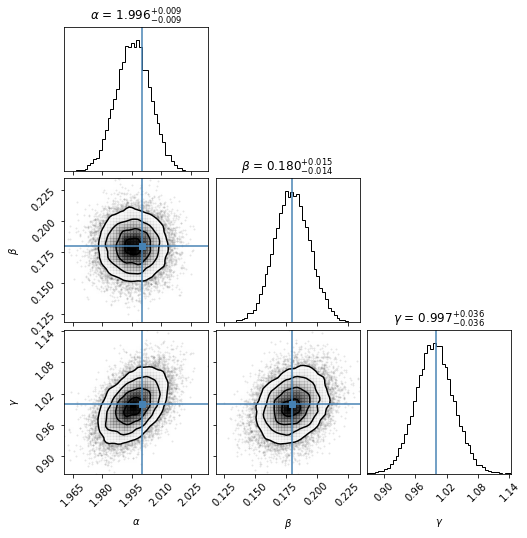

In [13]:
alpha_true = 2.
beta_true = 0.18
gamma_true = 1.

fig = corner.corner(
    flat_samples, bins=50, labels=labels, smooth=True, \
    truths=[alpha_true,beta_true,gamma_true],\
    show_titles=True,title_fmt=".3f");

In [14]:
labels_2 = [r"\alpha", r"\beta", r"\gamma"]
for i in range(3):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_2[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [15]:
g = flat_samples[:, 2]

def gaussian(x, mean, amplitude, s0):
    return amplitude * np.exp( - (x - mean)**2 / 2 /s0**2)

gamma: 0.9961118990860085 \pm 0.00029844378176186354
sigma: -0.03628877946762161 \pm 0.00029845282057352796


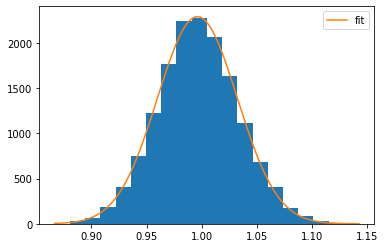

In [16]:
bin_heights, bin_borders, _ = plt.hist(g, bins=20)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

perr = np.sqrt(np.diag(pcov))
print('gamma:',popt[0],'\pm',perr[0])
print('sigma:',popt[2],'\pm',perr[2])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()